# Finalna wersja

### Zrobione na podstawie https://ahrs.readthedocs.io/en/latest/filters/ekf.html
#### Kod wygenerował wynik ~ 0.475

In [151]:
from scipy.linalg import block_diag
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import norm

train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

# Redukcja biasu 
bias_redX = test_data['GyroX'][:100].mean()
bias_redY = test_data['GyroY'][:100].mean()
bias_redZ = test_data['GyroZ'][:100].mean()

test_data['GyroX'] -= bias_redX
test_data['GyroY'] -= bias_redY
test_data['GyroZ'] -= bias_redZ

test_data['GyroX'] /= 1000
test_data['GyroY'] /= 1000
test_data['GyroZ'] /= 1000

In [152]:
# Funkcje pomocnicze
def normalize(v):
    """Normalizuje wektor."""
    return v / norm(v)

def quaternion_multiply(q1, q2):
    """Mnożenie kwaternionów."""
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    return np.array([
        w1*w2 - x1*x2 - y1*y2 - z1*z2,
        w1*x2 + x1*w2 + y1*z2 - z1*y2,
        w1*y2 - x1*z2 + y1*w2 + z1*x2,
        w1*z2 + x1*y2 - y1*x2 + z1*w2
    ])

def quaternion_to_euler(q):
    """Konwersja kwaternionów na kąty Eulera."""
    w, x, y, z = q
    roll = np.arctan2(2 * (w*x + y*z), 1 - 2 * (x*x + y*y))
    pitch = np.arcsin(2 * (w*y - z*x))
    yaw = np.arctan2(2 * (w*z + x*y), 1 - 2 * (y*y + z*z))
    return np.degrees(roll), np.degrees(pitch), np.degrees(yaw)

def ekf_filter(data, process_noise, measurement_noise, roll_scale_factor, roll_threshold):
    n = len(data)
    dt = data['Time'].diff().fillna(method='bfill').to_numpy()

    # Inicjalizacja kwaternionów i macierzy
    q = np.array([1, 0, 0, 0], dtype=np.float64)  # Początkowy kwaternion
    P = np.eye(4) * 0.01  # Początkowa macierz kowariancji
    Q = np.eye(4) * process_noise  # Szum procesu dla kwaternionów
    R = np.eye(3) * measurement_noise  # Szum pomiarowy (akcelerometr)

    roll_est, pitch_est, yaw_est = [], [], []
    yaw = 0  # Początkowy kąt yaw (całkowany z żyroskopu)

    for t in range(n):
        gyro = data[['GyroX', 'GyroY', 'GyroZ']].iloc[t].to_numpy() * np.pi / 180
        acc = data[['AccX', 'AccY', 'AccZ']].iloc[t].to_numpy()
        acc = normalize(acc)

        # Predykcja
        omega = np.hstack(([0], gyro))
        q_dot = 0.5 * quaternion_multiply(q, omega)
        q += q_dot * dt[t]
        q = normalize(q)

        # Gradient dynamiki (F) dla aktualizacji kowariancji
        F = np.eye(4) + dt[t] * np.array([
            [0, -gyro[0], -gyro[1], -gyro[2]],
            [gyro[0], 0, gyro[2], -gyro[1]],
            [gyro[1], -gyro[2], 0, gyro[0]],
            [gyro[2], gyro[1], -gyro[0], 0]
        ])
        P = F @ P @ F.T + Q

        # Korekcja
        h = np.array([
            2 * (q[1]*q[3] - q[0]*q[2]),
            2 * (q[0]*q[1] + q[2]*q[3]),
            q[0]**2 - q[1]**2 - q[2]**2 + q[3]**2
        ])
        H = 2 * np.array([
            [-q[2],  q[3], -q[0],  q[1]],
            [ q[1],  q[0],  q[3],  q[2]],
            [ q[0], -q[1], -q[2],  q[3]]
        ])

        y = acc - h
        S = H @ P @ H.T + R
        K = P @ H.T @ np.linalg.inv(S)
        q += K @ y
        q = normalize(q)
        P = (np.eye(4) - K @ H) @ P

        # Całkowanie żyroskopu dla yaw
        yaw += gyro[2] * dt[t]

        # Konwersja na kąty Eulera
        roll, pitch, yaw_deg = quaternion_to_euler(q)

        # Liniowe przeskalowanie wpływu roll na pitch od progu
        if abs(roll) > roll_threshold:
            scale_factor = max(0, 1 - (abs(roll) - roll_threshold) * roll_scale_factor)
            pitch *= scale_factor

        roll_est.append(roll)
        pitch_est.append(pitch)
        yaw_est.append(np.degrees(yaw))

    return np.array(roll_est), np.array(pitch_est), np.array(yaw_est)

# Parametry skalowania
process_noise = 0.01
measurement_noise = 20
roll_scale_factor = 0.02  # Wpływ roll powyżej progu
roll_threshold = 30 # Próg dla tłumienia pitch

# Całkowanie z EKF
test_roll, test_pitch, test_yaw = ekf_filter(
    test_data,
    process_noise=process_noise,
    measurement_noise=measurement_noise,
    roll_scale_factor=roll_scale_factor,
    roll_threshold=roll_threshold
)

test_data['roll_pred'] = test_roll
test_data['pitch_pred'] = test_pitch
test_data['yaw_pred'] = test_yaw

C:\Users\konra\AppData\Local\Temp\ipykernel_10188\181857652.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dt = data['Time'].diff().fillna(method='bfill').to_numpy()


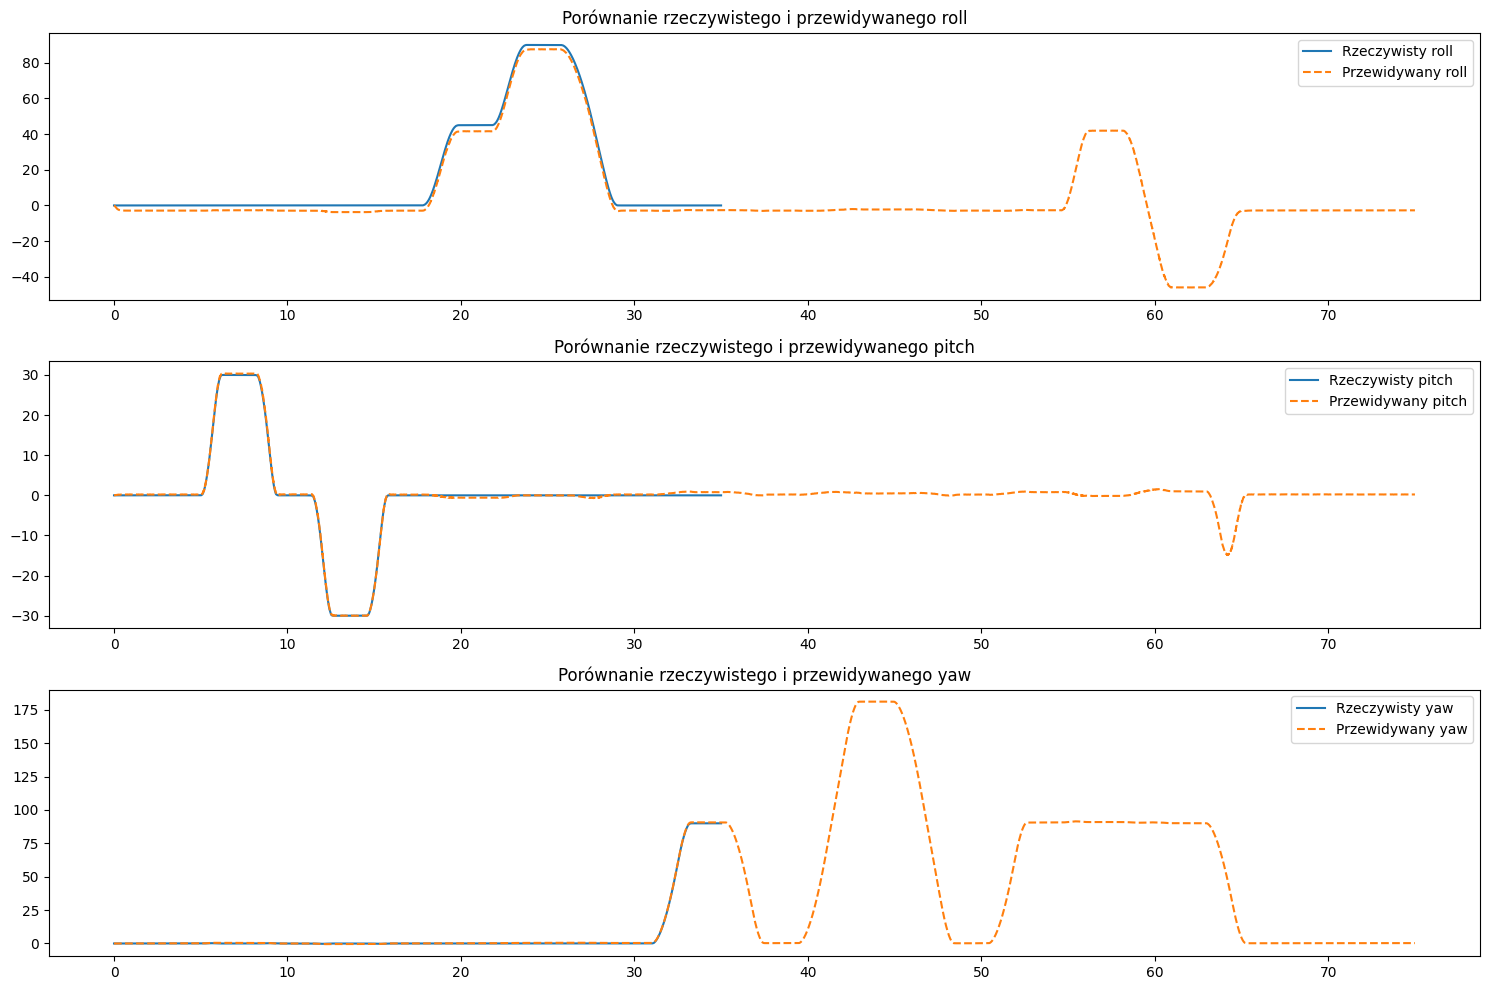

In [153]:
# Wykresy przed drugą redukcją biasu

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(train_data['Time'], train_data['roll'], label='Rzeczywisty roll')
plt.plot(test_data['Time'], test_data['roll_pred'], label='Przewidywany roll', linestyle='--')
plt.legend()
plt.title('Porównanie rzeczywistego i przewidywanego roll')

plt.subplot(3, 1, 2)
plt.plot(train_data['Time'], train_data['pitch'], label='Rzeczywisty pitch')
plt.plot(test_data['Time'], test_data['pitch_pred'], label='Przewidywany pitch', linestyle='--')
plt.legend()
plt.title('Porównanie rzeczywistego i przewidywanego pitch')

plt.subplot(3, 1, 3)
plt.plot(train_data['Time'], train_data['yaw'], label='Rzeczywisty yaw')
plt.plot(test_data['Time'], test_data['yaw_pred'], label='Przewidywany yaw', linestyle='--')
plt.legend()
plt.title('Porównanie rzeczywistego i przewidywanego yaw')

plt.tight_layout()
plt.show()

In [154]:
## Drugi raz redukuje bias

roll_bias = train_data['roll'][:7000].mean() - test_data['roll_pred'][:7000].mean()
pitch_bias = train_data['pitch'][:7000].mean() - test_data['pitch_pred'][:7000].mean()
yaw_bias = train_data['yaw'][:7000].mean() - test_data['yaw_pred'][:7000].mean()

test_data['roll_pred'] += roll_bias
test_data['pitch_pred'] += pitch_bias
test_data['yaw_pred'] += yaw_bias

print(f"Roll bias: {roll_bias}")
print(f"Pitch bias: {pitch_bias}")
print(f"Yaw bias: {yaw_bias}")

Roll bias: 2.9477487744658113
Pitch bias: -0.10634532101331017
Yaw bias: -0.20052010522333408


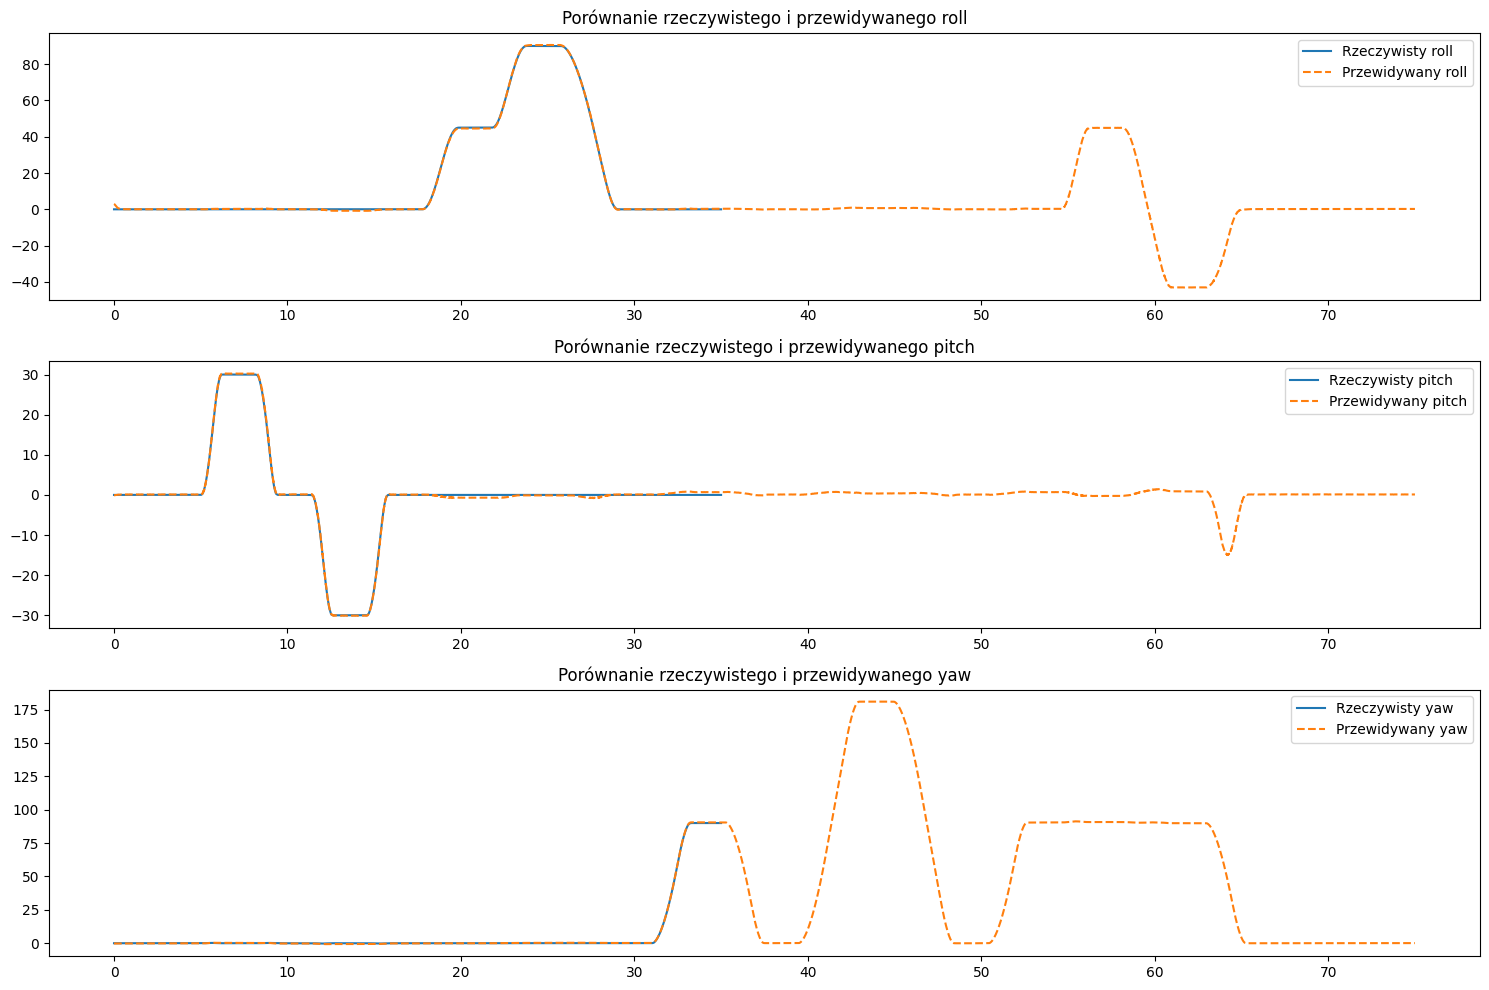

In [155]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(train_data['Time'], train_data['roll'], label='Rzeczywisty roll')
plt.plot(test_data['Time'], test_data['roll_pred'], label='Przewidywany roll', linestyle='--')
plt.legend()
plt.title('Porównanie rzeczywistego i przewidywanego roll')

plt.subplot(3, 1, 2)
plt.plot(train_data['Time'], train_data['pitch'], label='Rzeczywisty pitch')
plt.plot(test_data['Time'], test_data['pitch_pred'], label='Przewidywany pitch', linestyle='--')
plt.legend()
plt.title('Porównanie rzeczywistego i przewidywanego pitch')

plt.subplot(3, 1, 3)
plt.plot(train_data['Time'], train_data['yaw'], label='Rzeczywisty yaw')
plt.plot(test_data['Time'], test_data['yaw_pred'], label='Przewidywany yaw', linestyle='--')
plt.legend()
plt.title('Porównanie rzeczywistego i przewidywanego yaw')

plt.tight_layout()
plt.show()

In [156]:
# Zapisywanie do pliku

submission = pd.DataFrame({
    'Id': test_data.index + 1,
    'pitch': test_data['pitch_pred'],
    'roll': test_data['roll_pred'],
    'yaw': test_data['yaw_pred']
})

submission.to_csv('results/sample-submission.csv', index=False)
print("Wyniki zapisano do pliku 'sample-submission.csv'")

Wyniki zapisano do pliku 'sample-submission.csv'
